In [1]:
import torch
from torch import nn
import model_runner
import embeddings
import dataset
import os

### Importing the dataset

In [ ]:
# Reader to get train and val data from csv
reader = dataset.csv_reader()

# Open formatted_train.csv
train_path = os.path.join(os.path.curdir, "dataset", "formatted_train.csv")
reader.open_csv(train_path, skip_header=True)
train_reviews = reader.read(-1)

# And formatted_val.csv
val_path = os.path.join(os.path.curdir, "dataset", "formatted_val.csv")
reader.open_csv(val_path, skip_header=True)
val_reviews = reader.read(-1)

### Embedding text reviews to vector representations

In [ ]:
# Intialize the embedder to use the glove-wiki-gigaword-50 embedding dictionary
# https://github.com/piskvorky/gensim-data#:~:text=org/licenses/pddl/-,glove%2Dwiki%2Dgigaword%2D50,-400000
review_embedder = embeddings.review_embedder(embedding_model="glove-wiki-gigaword-50")

In [ ]:
# This dict denotes how review labels (strings) should be mapped to one-hot encodings (tensors)
# Note that this mapping is for the original dataset,the dataset with remapped labels will look different
review_label_mapping = {
    "negative": torch.tensor([1., 0.]),
    "positive": torch.tensor([0., 1.]),
}

In [ ]:
# Creating final embeddings
# Based on this dict and the embedding scheme selected above (glove-wiki-gigaword-50),
# we can embed our review text and labels to tensors
# 
# Note that there are a few extra parameters to the embedder which aren't shown below:
# 
# oov_feature: creates an extra label feature which is zero usually, except for when a word
#   of a review can't be embedded because it is not contained in the word vector list
#   of the chosen embedding scheme (the word is then "out-of-vocab"). When an OOV word
#   is encountered in the review text and oov_feature is True (default), then the resulting
#   word vector is a bunch of zeroes, plus a one in the oov_feature postition; when
#   this happens and oov_feature is False, the word is simply skipped.
# 
# title_body_feature: similar to oov_feature, this creates an extra label feature which is
#   zero for words appearing in the title of the review and one for words appearing in the
#   body of the review.
# train_features, train_labels = review_embedder.embed_dataset_features_and_labels(train_reviews, review_label_mapping)
# test_features, test_labels = review_embedder.embed_dataset_features_and_labels(test_reviews, review_label_mapping)

In [ ]:
# New sampler, which can run on the full dataset
# TODO desc
train_sampler = embeddings.batched_review_embedder_sampler(train_reviews, review_embedder, review_label_mapping, batch_size=50)
val_sampler = embeddings.batched_review_embedder_sampler(val_reviews, review_embedder, review_label_mapping, batch_size=50)

# Testing the samplers
x_sample, y_sample = next(iter(train_sampler))
x_sample, x_sample.data.shape, x_sample.batch_sizes.shape, y_sample.shape

(PackedSequence(data=tensor([[ 0.0869, -0.1942, -0.2427,  ..., -0.1694,  0.0000,  0.0000],
         [ 0.3147,  0.4166,  0.1348,  ..., -0.1157,  0.0000,  0.0000],
         [ 0.5705, -0.0078, -0.7077,  ...,  0.8394,  0.0000,  0.0000],
         ...,
         [-0.0266,  1.3357, -1.0280,  ..., -0.2549,  0.0000,  1.0000],
         [-0.0871, -0.0830,  1.6967,  ..., -0.6722,  0.0000,  1.0000],
         [-0.5025,  1.2178, -0.8007,  ...,  0.6864,  0.0000,  1.0000]]), batch_sizes=tensor([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 49,
         49, 49, 49, 49, 49, 48, 48, 48, 47, 47, 47, 47, 47, 45, 44, 44, 44, 43,
         41, 41, 40, 39, 38, 37, 37, 37, 37, 37, 37, 37, 36, 35, 34, 33, 33, 33,
         33, 32, 32, 32, 32, 30, 28, 27, 27, 26, 26, 25, 25, 25, 24, 23, 22, 22,
         22, 21, 21, 20, 20, 20, 20, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 18,
         17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15,
         15, 15, 14, 14, 14, 14, 13, 13, 

### Model creation

In [2]:
class review_LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_classifier: nn.Module):
        super().__init__()
        self._LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self._output_classifier = output_classifier
        self._hidden_size = hidden_size
        super().add_module("LSTM", self._LSTM)
    
    def forward(self, x: torch.Tensor | nn.utils.rnn.PackedSequence):
        # Give the review data to the LSTM to munch on
        output, (h_n, c_n) = self._LSTM.forward(x)
        
        # c_n is the cell state of the LSTM given all the data it has seen so far, and is supposed to
        # represent the LSTM's overall interpretation of the data; it can be used as a feature vector
        # for the output classifier to make a final class prediction. Reshape it to [batch_size x hidden_size],
        # then feed it to the output classifier
        c_n = torch.reshape(c_n, (-1, self._hidden_size))
        yhat = self._output_classifier.forward(c_n)
        
        # Return the results from the output classifier
        return yhat

In [3]:
input_size = 52
hidden_size = 100
output_size = 2

output_classifier = nn.Linear(hidden_size, output_size)

model = review_LSTM(input_size, hidden_size, output_classifier)

### Model training

In [4]:
# Model optimizer objects
optim = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

In [5]:
# Create a model runner to handle training
runner = model_runner.runner(model_name="LSTM_test_full_formatted_dataset", model=model, optimizer=optim, loss_fn=loss_fn)

In [ ]:
# Train that model!
runner.train(train_sampler, val_sampler, num_epochs=1, autosave_interval_epochs=1)

NameError: name 'train_sampler' is not defined

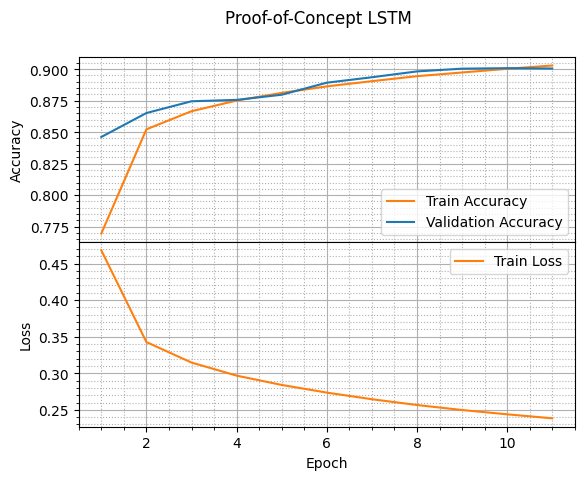

([0.7694846219953645,
  0.8522622984973567,
  0.8666168389801818,
  0.8750811219042163,
  0.8811901351597697,
  0.886341831818537,
  0.8905028776791062,
  0.8944555847808536,
  0.8973843068829918,
  0.9003250084637621,
  0.9029250761738586],
 [0.8461725961929087,
  0.865197635828408,
  0.8745247385932055,
  0.8756330742355714,
  0.8797184994135404,
  0.8892851860108042,
  0.8936018616705451,
  0.8982477046827181,
  0.9004227092139775,
  0.900820626709639,
  0.9005477094743948])

In [6]:
runner.plot_model_performance(title="Proof-of-Concept LSTM", show_loss=True)
runner._train_acc_history, runner._val_acc_history